# Logistic Regression on the Diabetes Dataset with pipelines and Cross-Validation

## By Christopher Hauman
<br>

A thank you Keshav Dhandhania for creating the fantastic barplot we'll use in his article [End-to-End Data Science Example: Predicting Diabetes with Logistic Regression](https://towardsdatascience.com/end-to-end-data-science-example-predicting-diabetes-with-logistic-regression-db9bc88b4d16). His article is a great place to start on using logistic regression for this dataset. We're going to add some complexity to optimize this model. 
<br>

This is a sequel to my guides on [K-Means Classification on the Iris Dataset with scikit-learn](https://nbviewer.jupyter.org/github/chrisman1015/Unsupervised-Learning/blob/master/K-Means%20Classification%20on%20the%20Iris%20Dataset%20with%20scikit-learn/K-Means%20Classification%20on%20the%20Iris%20Dataset%20with%20scikit-learn.ipynb) and [KNN Classification on the Iris Dataset with scikit-learn](https://nbviewer.jupyter.org/github/chrisman1015/Supervised-Learning/blob/master/KNN%20Classification%20on%20the%20Iris%20Dataset%20with%20scikit-learn/Iris.ipynb). We covered gridsearch cross validation in the knn guide and using pipelines to transform data in the k-means guide. We'll use both of these in conjunction here.

<br>

The data for this guide was taken from the [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database). Feel free to check it out if you have any questions about the data.

In [17]:
# there are a few depreciation and futurewarnings that could arise. We'll simply disable them for this guide

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [20]:
# import usual packages

# for computing the accuracy of the model.
from sklearn import metrics

# datasets has the dataset
from sklearn import datasets

# pandas and numPy for DataFrames and arrays
import pandas as pd
import numpy as np

# pyplot and seaborn for plots
import matplotlib.pyplot as plt
import seaborn as sns

We'll load the data, create the feature and target values, and create the train/test splits as usual

In [28]:
# load dataset
diabetes = pd.read_csv("diabetes.csv")
diabetes.head()

# load the data and target variables
X, y = diabetes.drop(['diabetes'], axis=1), diabetes.diabetes

from sklearn.model_selection import train_test_split

# take 25% of the data for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

We'll begin by perfoming logistic regression on the data the usual way. We initialize the model and then fit it to the data.

In [24]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

For those out there with statistics backgrounds, the [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) is a great way to visualize type 1 and 2 errors: 

In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[100  23]
 [ 26  43]]


We see the model correctly classified 143 out of 192 test values correct. We can get divide the confusion matrix by the total number of observations to get the frequency of each value:

In [26]:
confusion_matrix(y_test, y_pred)/len(y_test)

array([[0.52083333, 0.11979167],
       [0.13541667, 0.22395833]])

We see the current model has a 13.5% rate of false positives (type 1 error) and a 12% rate for false negatives (type 2 error). Needless to say, this model is far from effective.
<br>

Next, we'll introduce the classification report. This gives us some more detailed and descriptive statistics:
<br>

The **precision** contains the accuracy of the classifications for that variable (remember 0 is not having diabetes and 1 is having it).

**recall** contains ratio of true positives for that class to the total number of values in that class.

**F1** contains the frequency of correct positive predictions that were made for that class.


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       123
           1       0.65      0.62      0.64        69

    accuracy                           0.74       192
   macro avg       0.72      0.72      0.72       192
weighted avg       0.74      0.74      0.74       192



Finally, we'll print the accuacy score for the first logistic regression model.

In [29]:
# print accuracy score
print(logreg.score(X_test, y_test))

0.7447916666666666


We see our model was just under 75% accurate for the test data. Let's take a look at the a barplot which displays the different factors by their importance to the model:

Text(0.5, 0, 'Importance')

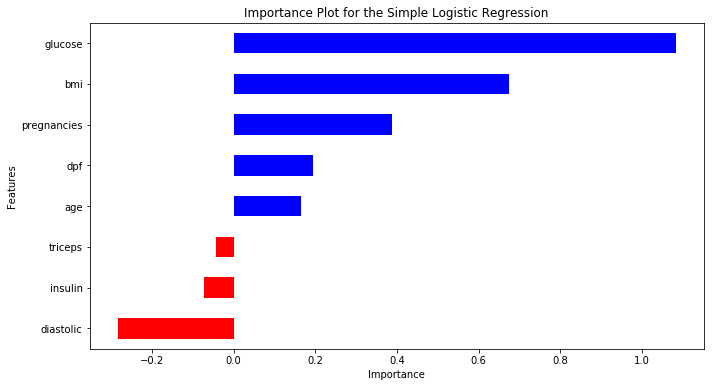

In [35]:
coeff = list(logreg.coef_[0])
labels = list(X_train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
plt.title("Importance Plot for the Simple Logistic Regression")
plt.xlabel('Importance')

We see the current model considers dpf and pregnancies the most important factors for predicting diabetes. If you're familiar with the topic, this shouldn't sound right. It's quite likely that the scale of some of these variables is skewing the model. To fix this, we'll start normalizing the data in our models from now on.

***
### StandardScaler Logreg Model
Create the same model with StandardScaler first in a pipeline. This will normalize the data across features. We'll make the same importance plot and compute the accuracy score for this model as well.

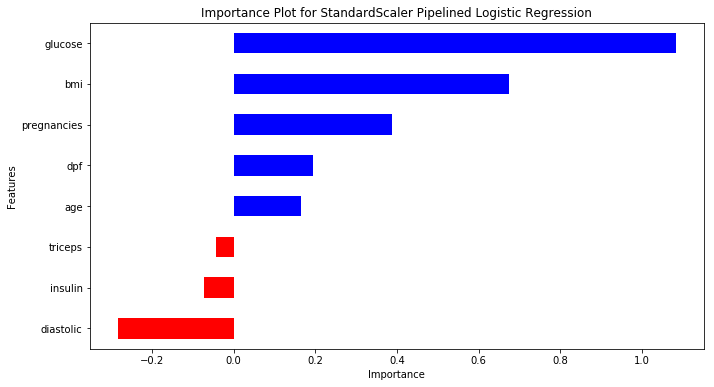

0.7760416666666666


In [40]:
# Scaled version

# take 25% of the data for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# initialize the algorithms
standardscaler = StandardScaler()
logreg = LogisticRegression(solver='liblinear')

# create the pipeline and fit the data
pipeline = make_pipeline(standardscaler, logreg)
normalized = pipeline.fit(X_train, y_train) 

coeff = list(pipeline.steps[1][1].coef_[0])
labels = list(X_train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
plt.title("Importance Plot for StandardScaler Pipelined Logistic Regression")
plt.xlabel('Importance')
plt.show()
print(pipeline.score(X_test, y_test))

We see the model increased to about 77% accuracy. This is reflected in the importance plot, which now shows glucose and bmi to be the best predictors for diabetes. 

***
### Normalized Logreg Model

We'll also try a pipeline model with Normalizer instead of StandardScaler, which normalizes across each observation:

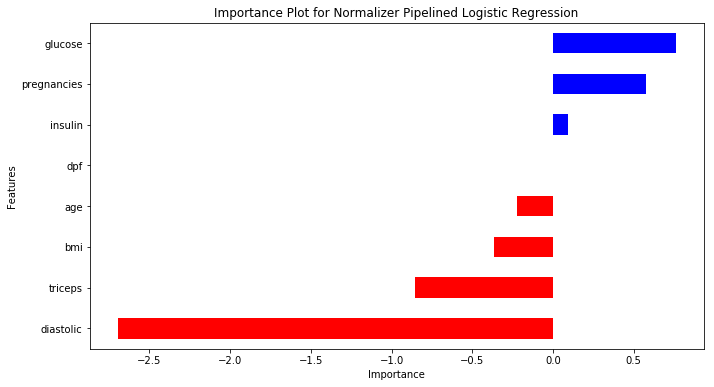

The pipeline2 test score is 0.6197916666666666


In [42]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

from sklearn.preprocessing import Normalizer

# initialize the algorithms
normalizer = Normalizer()
logreg2 = LogisticRegression(solver='liblinear')

# create the pipeline and fit the data
pipeline2 = make_pipeline(normalizer, logreg2)
pipeline2.fit(X_train, y_train) 

coeff = list(pipeline2.steps[1][1].coef_[0])
labels = list(X_train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')
plt.title("Importance Plot for Normalizer Pipelined Logistic Regression")
plt.show()
print("The pipeline2 test score is", pipeline2.score(X_test, y_test))

We see the normalizer is much worse for this case. We'll stick with StandardScaler.

***
### GridsearchCV on Unscaled Model

But what about the other parameters in the logistic regression? Let's use grid search cross validation to find the best parameters on the original (unscaled) data.
<br>

**C** controls the inverse of the regularization strength. A large C can lead to an overfit model, while a small C can lead to an underfit model. Optimizing C is crucial for logistic regression.
<br>

**penalty** determines the penalty function used to fit the model

In [44]:
from sklearn.model_selection import GridSearchCV

# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C':c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression(solver='liblinear')

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 31.622776601683793, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.7673913043478261


We see the cross validation determined the best value for C is 31.6 and the best penalty is 'l2.'
<br>

As we move forward, keep in mind the accuracy score was 76.74% with a C value of 31.62.

***
### GridsearchCV on StandardScaled Data

In [45]:
from sklearn.model_selection import GridSearchCV

# Create the hyperparameter grid
c_space2 = np.logspace(-5, 8, 15)
param_grid2 = {'C':c_space2, 'penalty': ['l1', 'l2']}

standardscaler2 = StandardScaler()

# Instantiate the logistic regression classifier: logreg
logreg2 = LogisticRegression(solver='liblinear')

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg2, param_grid2, cv=5)

# create the pipeline and fit the data
pipeline_cv = make_pipeline(standardscaler2, logreg_cv)

# Fit it to the training data
pipeline_cv.fit(X_train, y_train)

print("Tuned Logistic Regression Parameter: {}".format(pipeline_cv.steps[1][1].best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(pipeline_cv.steps[1][1].best_score_))

Tuned Logistic Regression Parameter: {'C': 0.05179474679231213, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.7673913043478261


Note the C value is much different for the scaled model, but we had the same accuracy score! The C value was optimized for each of the scaled and nonscaled models, and ultimately provided the same accuracy.